In [1]:
import xarray as xr
import geopandas as gpd
from earthkit.climate import shapes

In [2]:
dataset = xr.open_dataset("test_data/era5_temperature_europe_2015.grib", chunks={'time': 1})
dataarray = dataset.t2m
geodataframe = gpd.read_file("test_data/nuts/NUTS_RG_60M_2021_4326_LEVL_0.geojson")

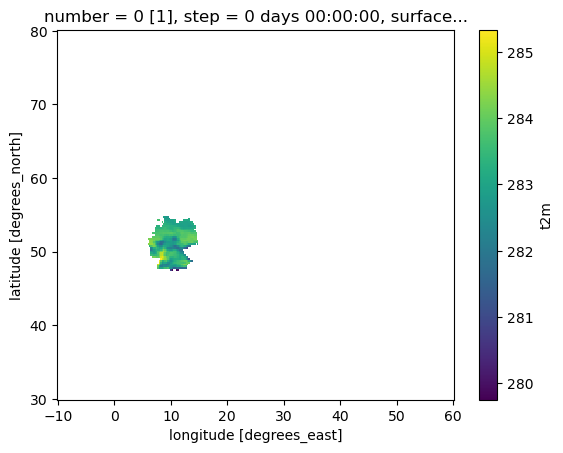

In [3]:
masked_data = shapes.masks(dataarray, geodataframe)
masked_data.sel(FID='DE').mean(dim='time').plot()

In [4]:
reduced_data = shapes.reduce(dataarray, geodataframe)
reduced_data

<xarray.DataArray 't2m' (FID: 37, time: 1460)>
array([[278.70923, 279.765  , 279.77222, ..., 275.24063, 276.06476,
        278.1447 ],
       [257.4673 , 256.88065, 264.83875, ..., 266.2654 , 271.9407 ,
        267.0766 ],
       [275.7629 , 275.43472, 275.91312, ..., 264.8501 , 266.2538 ,
        264.78198],
       ...,
       [270.75067, 271.9417 , 274.1975 , ..., 267.43457, 271.5376 ,
        269.48703],
       [274.46927, 273.63748, 275.65186, ..., 273.50412, 276.47733,
        275.96637],
       [272.67392, 272.93872, 273.56546, ..., 274.4205 , 274.17746,
        273.82974]], dtype=float32)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2015-01-01 ... 2015-12-31T18:00:00
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
    valid_time  (time) datetime64[ns] 2015-01-01 ... 2015-12-31T18:00:00
  * FID         (FID) object 'DK' 'RS' 'EE' 'EL' 'ES' ... 'CY' 'CZ' 'DE' 'NO'

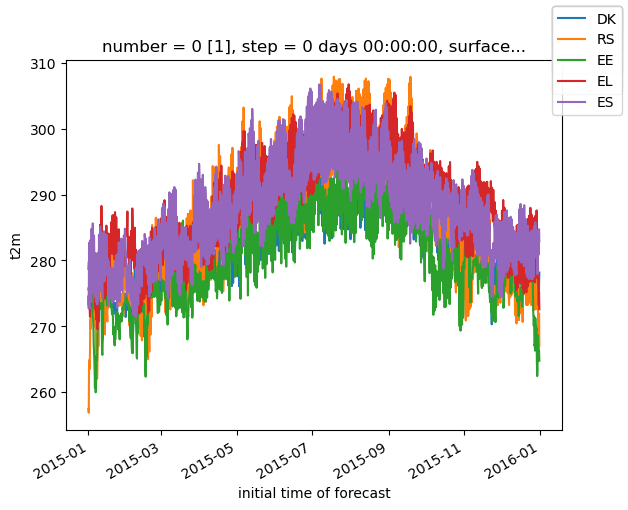

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1)
for fid in geodataframe.NUTS_ID[:5]:
    reduced_data.sel(FID=fid).plot(ax=ax, label=fid)
    fig.legend()
